# Testing lstm for future prediction

In [2]:
tf.__version__

'2.0.0-alpha0'

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

- using weather timeseries dataset
- https://www.bgc-jena.mpg.de/wetter/

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

In [5]:
csv_path, _ = os.path.splitext(zip_path)

In [6]:
# Preview of the data
df = pd.read_csv(csv_path)
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


- The data is recoreded every 10 minutes
- In an hour there are 6 observations and in a day there are 144 observation
- If you wan't to make a prediction 6 hours into the future using the observations of the 5 previous days
    - you would need a window size of 720 (5x144)

In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    '''
    This returns the window of time for a model to train on
    :param: dataset list/matrix : the dataset for the model to train on 
    :param: start_index int : Where is inside data do you want to start creating windows
    :param: end_index int : Where do you want to end creating windows
    :param: history_size int : the size of the past window of information
    :param: target_size int: How far into the future the model needs to learn
    '''
    
    data = [] # Stores the data for the training window
    labels = [] # Stores the data for the output

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

## Train Test Split

- In both the following tutorials, the first 300,000 rows of the data will be the training dataset, This amounts to ~2100 days worth of training data.
- There remaining will be the validation dataset. 

In [8]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

# Part 1: Forecast a univariate time series

- First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future

In [9]:
# Creating the data
uni_data = df['T (degC)'] #y
uni_data.index = df['Date Time'] # x
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb555c88320>],
      dtype=object)

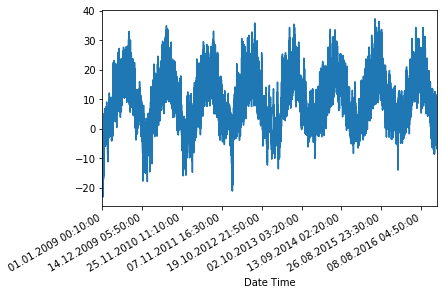

In [10]:
# Plot the data, to see what it looks like accross time
uni_data.plot(subplots=True)

In [11]:
# Turning the data y values into a matrix form (array) for normalization
uni_data = uni_data.values

In [12]:
uni_data

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [13]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean() # mean for the training data
uni_train_std = uni_data[:TRAIN_SPLIT].std() # standard deviation for the training data

# Normalization
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [14]:
uni_data

array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
       -1.55883897, -1.62715193])

# Creating a Window

- Let's now create the data for the univariate model. 
- For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step.

In [15]:
univariate_past_history = 20
univariate_future_target = 0

# For training the model :300000
#(299980, 20, 1) #(299980,)
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, # Data, start_index, end_index
                                           univariate_past_history,  # History_size
                                           univariate_future_target) # Target_size, the next timestep

In [16]:
# For testing the model 30000:
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [17]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [18]:
def create_time_steps(length):
    '''
    returns an array of numbers from -length to -1. i.e: create_timesteps(5) --> [-5, -4, -3, -2, -1]
    :param: length int: size of the timestep
    '''
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [19]:
def show_plot(plot_data, delta, title):
    '''
     - Plots the target data (y) with the time steps (X).
     - If the size of plot_data list is bigger than 1, i.e 3, the 0th index is the history (acctual data)
         the 1st index is the True future given by univariate function
         the 2nd index is the model prediction
    :params: plot_data dataframe/series: the data to plot
    :params: delta int: how fare into the future to move
    :params: title string: the title of the plot
    :returns: A plot of plot_data
    '''
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

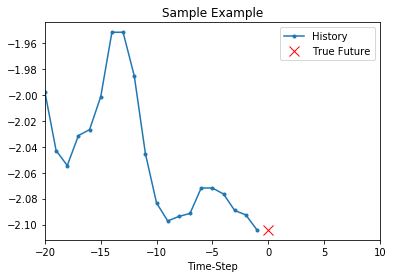

In [20]:
# Example for show_plot function
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

## Playing around with show plot func

In [21]:
def baseline(history):
    # returns the mean of the history as the model prediction
    return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

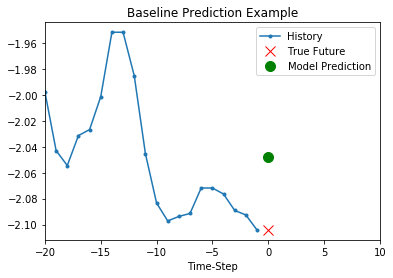

In [22]:
# plot the first window with the baseline func
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

## LSTMs

In [23]:
# using tf.data to shuffle, batch, and cache the dataset.

BATCH_SIZE = 256
BUFFER_SIZE = 10000

# Creating training slices and shuffling them
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# Creating testing slices and shuffling them
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

*This is what batching as shown above is doing to the data*
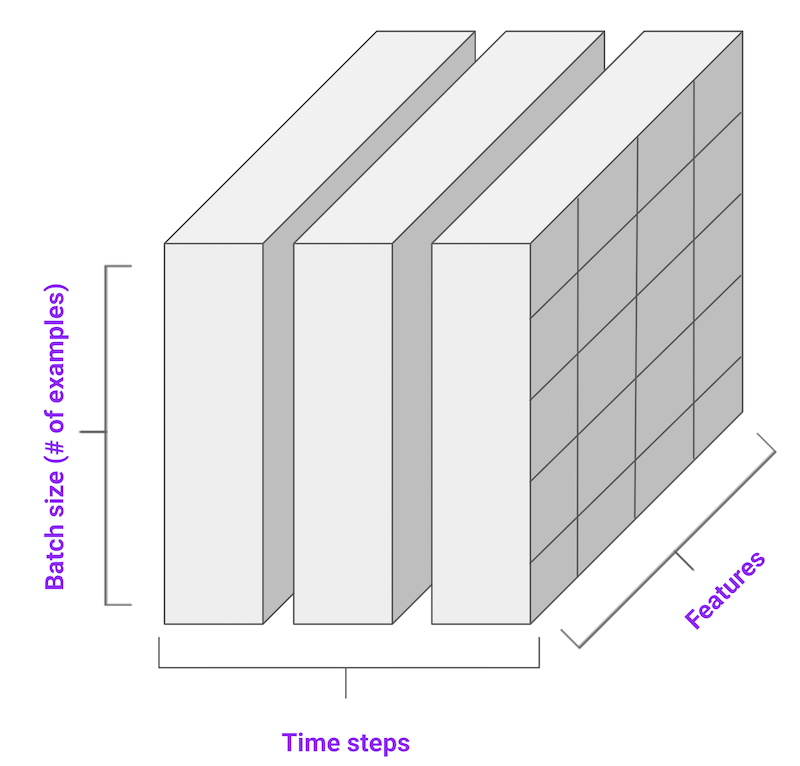

- As you can see that these look like windows and they are acctually going to be feed one by one
- So the input shape is going to be x_train_uni.shape[-2:] --> (20, 1)
    - This is the shape of an individual window
- Note how we are not using x_train_uni.shape --> (299980, 20, 1), because that is not a single window instead it is a set of windows

### Building the LSTM

In [24]:
# Building the model
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [28]:
for x, y in val_univariate.take(1):
    print(x)

tf.Tensor(
[[[0.642228  ]
  [0.63643877]
  [0.63643877]
  ...
  [0.60401906]
  [0.60054552]
  [0.60054552]]

 [[0.63643877]
  [0.63643877]
  [0.63643877]
  ...
  [0.60054552]
  [0.60054552]
  [0.59938767]]

 [[0.63643877]
  [0.63643877]
  [0.63643877]
  ...
  [0.60054552]
  [0.59938767]
  [0.59938767]]

 ...

 [[0.6445437 ]
  [0.6445437 ]
  [0.64801724]
  ...
  [0.65264863]
  [0.65264863]
  [0.65264863]]

 [[0.6445437 ]
  [0.64801724]
  [0.6445437 ]
  ...
  [0.65264863]
  [0.65264863]
  [0.65264863]]

 [[0.64801724]
  [0.6445437 ]
  [0.65149078]
  ...
  [0.65264863]
  [0.65264863]
  [0.65264863]]], shape=(256, 20, 1), dtype=float64)


In [26]:
# Training the model
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0262 - val_loss: 0.0196
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0253 - val_loss: 0.0182
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0227 - val_loss: 0.01

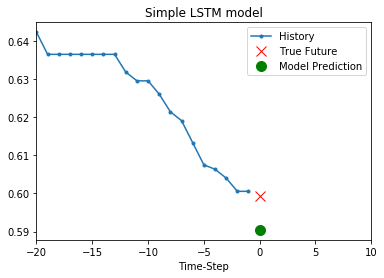

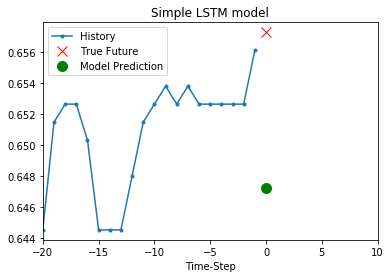

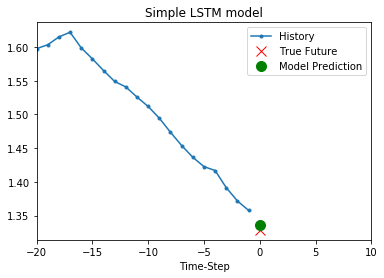

In [27]:
# Predictions on the model
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

<strong> As can be seen the results are better then the base line alone </strong>